<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/activity_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [170]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to change which query is being used
QUERY_NAME = "el_5.sql"

# change to alter the number of random traces being selected
# set value to None in order to use the full dataset
NUM_TRACES = 1000

# change to alter the prefix/suffix length
PREFIX_LENGTH = 5

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

# change to tune hyperparameters






## Section 1: Loading event log

In [8]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from google.colab import auth
auth.authenticate_user()

In [10]:
# this assumes that the user has access to the mimic-iii dataset 
# replace project name to the project containing mimic-iii
project_name = "processmining-367815" 
from google.cloud import bigquery
client = bigquery.Client(project=project_name)

In [11]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

In [12]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,105764,Transfer,2134-03-01 00:38:40
1,112013,Transfer,2187-02-12 00:42:40
2,150193,Transfer,2192-06-01 01:13:39
3,144980,Transfer,2169-08-14 00:30:19
4,122192,Transfer,2120-04-15 00:32:00
...,...,...,...
230665,178246,Admitted,2134-10-29 07:15:00
230666,148472,Admitted,2106-07-12 18:52:00
230667,156806,Admitted,2123-09-08 06:45:00
230668,100375,Admitted,2129-05-02 00:12:00


## Section 2: Process Discovery

In [13]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-13-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.8/dist-packages/pm4py/utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype("string")
/usr/local/lib/python3.8/dist-packages/pm4py/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

Number of cases: 42652
Number of events: 230668
Start events: {'Admitted': 36389, 'Transfer': 6208, 'Discharged': 55}
End events: {'Discharged': 35125, 'Left ICU': 7510, 'Transfer': 14, 'Admitted': 3}


In [14]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model

event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])

In [15]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

/usr/local/lib/python3.8/dist-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


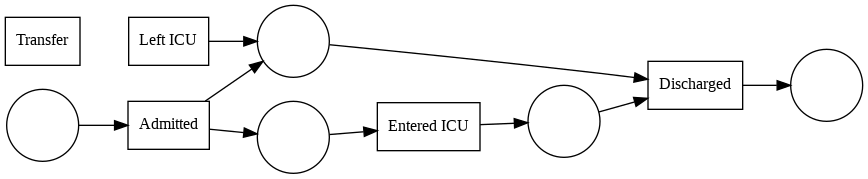

In [16]:
import graphviz
pm.view_petri_net(petri_net=net)

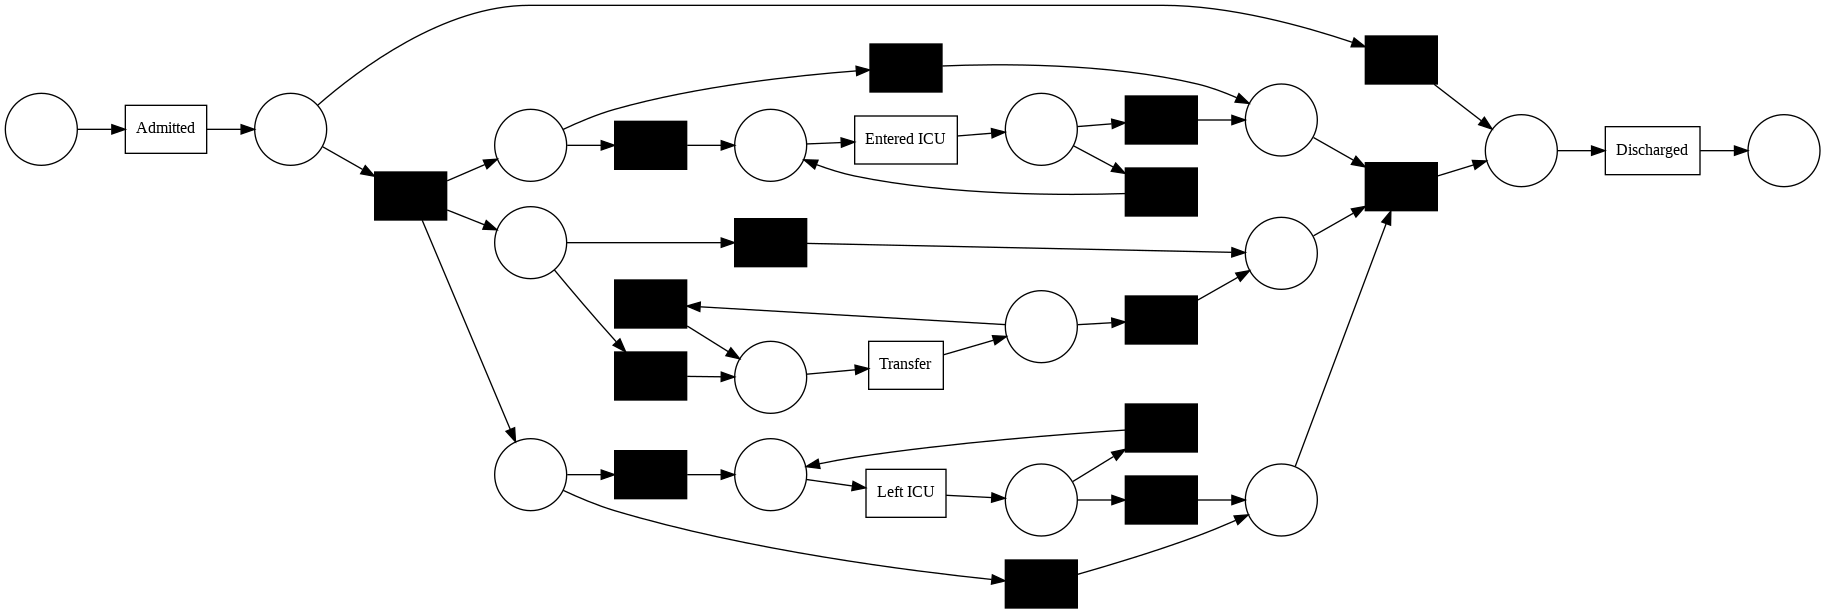

In [17]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

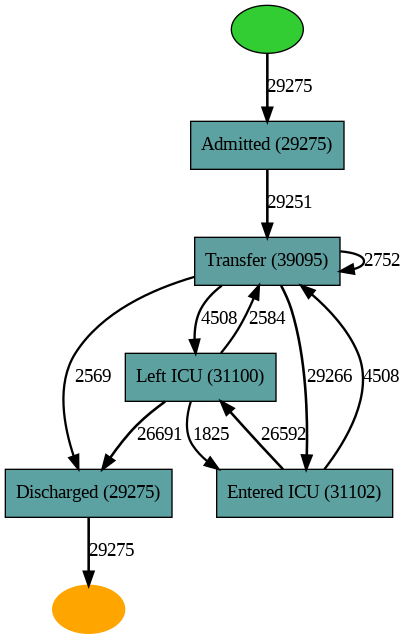

In [18]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

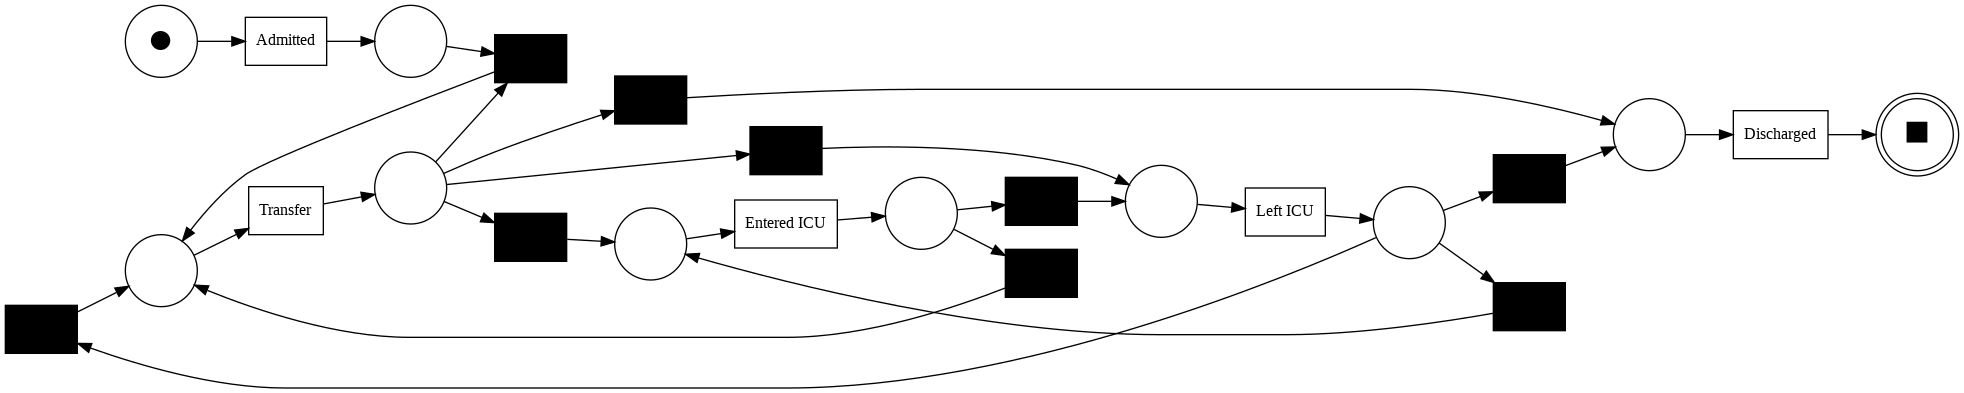

In [19]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

## Section 3: Data Pre Processing



In [171]:
from pandas.core.window.ewm import partial
import random

def partial_log(el, n):

  # select the first n cases to test the LSTM methodology
  # lets first add a trace column to the event_log
  el['trace'] = el.groupby(['patient']).ngroup()
  el = el[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
  # if n is None, return full event log
  if n is None:
    return el

  # initialise random seed and array of traces
  random.seed(9)
  random_traces = []

  for i in range(0,n):
    random_traces.append(random.randrange(0,n_cases))

  partial_el = event_log[event_log['trace'].isin(random_traces)]
  return partial_el


In [172]:
partial_el = partial_log(event_log, NUM_TRACES)
# partial_el

In [173]:
# lets represent each activity using a statically defined number
# this will prevent the need for using an embedding layer when traing the LSTM
unique_activities = partial_el['activity'].unique()
n_activities = len(unique_activities) + 1
encode_activity = {unique_activities[i-1] : f'{i}' for i in range(1,n_activities)}

# lets also create a second dictionary that will be used to decode predicted activities
decode_activity = {f'{i}' : unique_activities[i-1] for i in range(1, len(unique_activities)+ 1)}
encode_activity, decode_activity


({'Admitted': '1',
  'Transfer': '2',
  'Entered ICU': '3',
  'Left ICU': '4',
  'Discharged': '5'},
 {'1': 'Admitted',
  '2': 'Transfer',
  '3': 'Entered ICU',
  '4': 'Left ICU',
  '5': 'Discharged'})

In [174]:
# calculate time deltas for prefix and suffix sequences
def calculate_time_deltas(p, s):
  p_deltas, s_deltas = [], []
  f = '%Y-%d-%m %H:%M:%S'
  for i in range(PREFIX_LENGTH):
    if p[i] == '0' or p[i+1] == '0':
      p_deltas.append(0)

    else:
      delta = pd.to_datetime(p[i+1], format=f) - pd.to_datetime(p[i], format=f)
      p_deltas.append(delta.total_seconds())

  for i in range(PREFIX_LENGTH,0,-1):
    if s[i] == '0' or s[i-1] == '0':
      s_deltas.append(0)
    else:
      delta = pd.to_datetime(s[i], format=f) - pd.to_datetime(s[i-1], format=f)
      s_deltas.append(delta.total_seconds())
  
  return p_deltas, s_deltas[::-1]

In [175]:
import numpy as np

# create a new labeled data frame
def label(el):
  # initialise data frame 
 
  prefix_arr, suffix_arr, prefix_times_arr, suffix_times_arr, label_arr = [], [], [], [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces} 

  for t in unique_traces:
    traces[t] = el[:][el.trace == t]  
  
  for t in unique_traces:
    df = traces[t].sort_values(by='timestamp')
    activities, timestamps = [], []

    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)

      timestamp = df['timestamp'][i]
      timestamps.append(timestamp)

    
    length = len(activities)
    
    for i in range(length):

      label = activities[i]
      prefix = activities[:i]
      prefix_times = timestamps[:i+1]

      suffix = []
      suffix_times = []

      if i != length - 1:
        suffix = activities[i+1:]

      if i != length:
        suffix_times = timestamps[i:]

      padding = []

      while len(prefix) + len(padding) < PREFIX_LENGTH:
        padding.append('0')
      
      prefix = padding + prefix
        
      padding = []
      
      while len(prefix_times) + len(padding) < PREFIX_LENGTH+1:
        padding.append('0')
      
      prefix_times =  padding + prefix_times

      while len(suffix) < PREFIX_LENGTH:
        suffix.append('0')

      while len(suffix_times) < PREFIX_LENGTH +1:
        suffix_times.append('0')

      prefix_deltas, suffix_deltas = calculate_time_deltas(prefix_times, suffix_times)
      # print(f'prefix t: {prefix_times} \n suffix t: {suffix_times}')

      prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
      suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
      prefix_times_arr.append(np.array(prefix_deltas))
      suffix_times_arr.append(np.array(suffix_deltas))
      label_arr.append(label)

  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'prefix time delta' : prefix_times_arr,
                       'suffix time delta' : suffix_times_arr,
                       'label' : label_arr})
 

In [176]:
from sklearn.model_selection import train_test_split

# label event log
labeled_el = label(partial_el)

# split event log into a train and test set  
train_el, test_el  = train_test_split(labeled_el, test_size=TEST_SIZE, random_state=9)
train_el


,prefix,suffix,prefix time delta,suffix time delta,label
2989,"[0, 0, 1, 2, 3]","[2, 2, 4, 5, 0]","[0.0, 0.0, 105.0, 0.0, 71618.0]","[5420.0, 9135.0, 268454.0, 784608.0, 0.0]",2
3016,"[0, 0, 1, 2, 3]","[2, 5, 0, 0, 0]","[0.0, 0.0, 48.0, 0.0, 222644.0]","[982597.0, 1437651.0, 0.0, 0.0, 0.0]",4
2437,"[0, 0, 1, 2, 3]","[5, 0, 0, 0, 0]","[0.0, 0.0, 36.0, 0.0, 121032.0]","[273672.0, 0.0, 0.0, 0.0, 0.0]",4
748,"[0, 1, 2, 3, 4]","[0, 0, 0, 0, 0]","[0.0, 81.0, 0.0, 656332.0, 264707.0]","[0, 0, 0, 0, 0]",5
2795,"[0, 0, 0, 0, 0]","[2, 3, 4, 5, 0]","[0, 0, 0, 0, 0]","[177.0, 97776.0, 86362.0, 439385.0, 0.0]",1
...,...,...,...,...,...
2104,"[0, 0, 0, 1, 2]","[4, 5, 0, 0, 0]","[0.0, 0.0, 0.0, 121.0, 0.0]","[1546749.0, 950.0, 0.0, 0.0, 0.0]",3
501,"[0, 0, 0, 0, 1]","[3, 4, 2, 5, 0]","[0.0, 0.0, 0.0, 0.0, 102.0]","[0.0, 257067.0, 320561.0, 3610.0, 0.0]",2
2686,"[0, 1, 2, 2, 3]","[5, 0, 0, 0, 0]","[0.0, 57.0, 259683.0, 0.0, 334504.0]","[360956.0, 0.0, 0.0, 0.0, 0.0]",4
348,"[0, 0, 0, 0, 1]","[3, 4, 3, 4, 5]","[0.0, 0.0, 0.0, 0.0, 109.0]","[0.0, 130327.0, 102003.0, 75081.0, 94900.0]",2


In [177]:
from copy import deepcopy

# declare the label of each activity in the test set as missing
# return actual labels as targets array for validation
def missing(el):
 
  # need to deepcopy targets to derefrence them from dataframe  
  targets = deepcopy(el['label'])
  el['label'] = 'missing'
  return el, targets.to_numpy()

In [178]:
# train_targets = train_el['label'].to_numpy()
test_el, test_targets = missing(test_el)
test_el, test_targets

(               prefix           suffix  \
 2138  [1, 2, 3, 4, 3]  [5, 0, 0, 0, 0]   
 2372  [0, 0, 0, 0, 1]  [3, 4, 5, 0, 0]   
 644   [0, 0, 0, 1, 2]  [4, 5, 0, 0, 0]   
 1269  [0, 0, 0, 1, 2]  [4, 5, 0, 0, 0]   
 286   [0, 0, 0, 0, 0]  [2, 3, 4, 5, 0]   
 ...               ...              ...   
 1697  [0, 1, 2, 3, 4]  [0, 0, 0, 0, 0]   
 3648  [0, 0, 1, 2, 3]  [5, 0, 0, 0, 0]   
 1554  [0, 0, 1, 2, 3]  [5, 0, 0, 0, 0]   
 2053  [0, 0, 0, 1, 2]  [4, 5, 0, 0, 0]   
 2559  [0, 0, 0, 0, 0]  [2, 3, 4, 5, 0]   
 
                                prefix time delta  \
 2138  [118.0, 0.0, 440946.0, 220992.0, 115487.0]   
 2372                  [0.0, 0.0, 0.0, 0.0, 57.0]   
 644             [0.0, 0.0, 0.0, 151.0, 332920.0]   
 1269                  [0.0, 0.0, 0.0, 67.0, 0.0]   
 286                              [0, 0, 0, 0, 0]   
 ...                                          ...   
 1697         [0.0, 75.0, 0.0, 614631.0, 56994.0]   
 3648         [0.0, 0.0, 60.0, 86160.0, 128700.0]   
 1554

In [179]:
# create validation set
train_el, validation_el = train_test_split(train_el, test_size=VALIDATION_SIZE, random_state=9)

In [180]:
from keras.utils import to_categorical

def format_input(el, train=False):

  prefix_x = np.array(el['prefix'])
  prefix_x = np.stack(prefix_x)
  prefix_x = prefix_x.reshape(prefix_x.shape[0], prefix_x.shape[1], 1)
  
  suffix_x = np.array(el['suffix'])
  suffix_x = np.stack(suffix_x)
  suffix_x = suffix_x.reshape(suffix_x.shape[0], suffix_x.shape[1], 1)

  prefix_td = np.array(el['prefix time delta'])
  prefix_td = np.stack(prefix_td)
  prefix_td = prefix_td.reshape(prefix_td.shape[0], prefix_td.shape[1], 1)

  suffix_td = np.array(el['suffix time delta'])
  suffix_td = np.stack(suffix_td)
  suffix_td = suffix_td.reshape(suffix_td.shape[0], suffix_td.shape[1], 1)

  x = np.concatenate(([prefix_x], [suffix_x], [prefix_td], [suffix_td]))

  y = np.array(el['label'])
  y = np.stack(y)
  
  if train is False:
    y_encoded = to_categorical(y,n_activities)
    return x, y_encoded
  
  return x, y

In [181]:
train_x, train_y = format_input(train_el) 
validation_x, validation_y = format_input(validation_el)
test_x, test_y = format_input(test_el, train=True)
test_x


array([[[[1.000000e+00],
         [2.000000e+00],
         [3.000000e+00],
         [4.000000e+00],
         [3.000000e+00]],

        [[0.000000e+00],
         [0.000000e+00],
         [0.000000e+00],
         [0.000000e+00],
         [1.000000e+00]],

        [[0.000000e+00],
         [0.000000e+00],
         [0.000000e+00],
         [1.000000e+00],
         [2.000000e+00]],

        ...,

        [[0.000000e+00],
         [0.000000e+00],
         [1.000000e+00],
         [2.000000e+00],
         [3.000000e+00]],

        [[0.000000e+00],
         [0.000000e+00],
         [0.000000e+00],
         [1.000000e+00],
         [2.000000e+00]],

        [[0.000000e+00],
         [0.000000e+00],
         [0.000000e+00],
         [0.000000e+00],
         [0.000000e+00]]],


       [[[5.000000e+00],
         [0.000000e+00],
         [0.000000e+00],
         [0.000000e+00],
         [0.000000e+00]],

        [[3.000000e+00],
         [4.000000e+00],
         [5.000000e+00],
         [0.000000e+

## Section 4: Predicting Missing Activities using LSTM

###4.1 Prefix LSTM

In [182]:
# forwards LSTM
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense, Softmax, Bidirectional, Embedding


prefix_LSTM = Sequential()
prefix_LSTM.add(Embedding(input_dim=n_activities, output_dim=50))
prefix_LSTM.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(PREFIX_LENGTH, 1)))
prefix_LSTM.add(Dense(n_activities, activation='softmax'))

prefix_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
prefix_LSTM.summary()
prefix_LSTM.fit(train_x[0], train_y, validation_data=(validation_x[0], validation_y), epochs=10)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 50)          300       
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 6)                 306       
                                                                 
Total params: 20,806
Trainable params: 20,806
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
74/74 [==============================] - 4s 21ms/step - loss: 1.5660 - accuracy: 0.6689 - val_loss: 0.8908 - val_accuracy: 0.8790
Epoch 2/10
74/74 [==============================] - 1s 13ms/step - loss: 0.4615 - accuracy: 0.8871 - val_loss: 0.3697 - val_accuracy: 0.8825
Epoch 3/10
74/74 [==============

###4.2 Suffix LSTM

In [183]:
# backwards LSTM

suffix_LSTM = Sequential()
suffix_LSTM.add(Embedding(input_dim=n_activities, output_dim=50))
suffix_LSTM.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(PREFIX_LENGTH, 1)))
suffix_LSTM.add(Dense(n_activities, activation='softmax'))

suffix_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
suffix_LSTM.summary()
suffix_LSTM.fit(train_x[1], train_y, validation_data=(validation_x[1], validation_y), epochs=10)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 50)          300       
                                                                 
 lstm_15 (LSTM)              (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 6)                 306       
                                                                 
Total params: 20,806
Trainable params: 20,806
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
74/74 [==============================] - 3s 13ms/step - loss: 1.5355 - accuracy: 0.3975 - val_loss: 0.9260 - val_accuracy: 0.7121
Epoch 2/10
74/74 [==============================] - 1s 8ms/step - loss: 0.5918 - accuracy: 0.8598 - val_loss: 0.5054 - val_accuracy: 0.8756
Epoch 3/10
74/74 [===============

###4.3 Bidirectional LSTM 

In [184]:
from pandas.core.internals import concat
# Bidirectional LSTM
from keras.layers import Bidirectional, Input, concatenate, average
from keras import Model

prefix_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_input')
suffix_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_input')

lstm_layer = LSTM(50)

prefix_layer = Bidirectional(lstm_layer, name='prefix_lstm')(prefix_input)
suffix_layer = Bidirectional(lstm_layer, name='suffix_lstm')(suffix_input)

merged = concatenate([prefix_layer, suffix_layer], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

bi_LSTM = Model(inputs=[prefix_input, suffix_input], outputs=output)
bi_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_LSTM.summary()
bi_LSTM.fit((train_x[0], train_x[1]), train_y,  validation_data=((validation_x[0], validation_x[1]), validation_y), epochs=10)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 suffix_input (InputLayer)      [(None, 5, 1)]       0           []                               
                                                                                                  
 prefix_lstm (Bidirectional)    (None, 100)          20800       ['prefix_input[0][0]']           
                                                                                                  
 suffix_lstm (Bidirectional)    (None, 100)          20800       ['suffix_input[0][0]']           
                                                                                            

###4.4 Bi-directional LSTM with timedeltas

In [185]:
# this LSTM takes additional two inputs:
# time deltas for the prefix events
# time deltas for the suffix events

prefix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_events_input')
suffix_events_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_events_input')

prefix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='prefix_deltas_input')
suffix_deltas_input = Input(shape=(PREFIX_LENGTH, 1), name='suffix_deltas_input')

merged_prefix = concatenate([prefix_events_input, prefix_deltas_input], axis=-1)
merged_suffix = concatenate([suffix_events_input, suffix_deltas_input], axis=-1)

lstm_layer = LSTM(50)

prefix_layer = Bidirectional(lstm_layer, name='prefix_lstm')(merged_prefix)
suffix_layer = Bidirectional(lstm_layer, name='suffix_lstm')(merged_suffix)

merged = concatenate([prefix_layer, suffix_layer], name='merged')

output = Dense(n_activities, activation='softmax', name='output')(merged)

bi_LSTM_td = Model(
    inputs=[prefix_events_input, suffix_events_input, prefix_deltas_input, suffix_deltas_input],
    outputs=output)

bi_LSTM_td.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_LSTM_td.summary()
bi_LSTM_td.fit(
    (train_x[0], train_x[1], train_x[2], train_x[3]),
    train_y,
    validation_data=((validation_x[0], validation_x[1], validation_x[2], validation_x[3]),
                     validation_y), epochs=10)



Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 prefix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 prefix_deltas_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                               
                                                                                                  
 suffix_events_input (InputLaye  [(None, 5, 1)]      0           []                               
 r)                                                                                         

##Section 5: Evaluation and Conformance Checking

In [186]:
def evaluate(predictions, verbose=False):
  correct = 0 
  incorrect = 0
  for i in range(len(test_targets)):
    prediction = np.argmax(predictions[i])
    if int(prediction) == int(test_targets[i]):
      correct += 1
    else:
      if verbose:
        print(f"predicted : {prediction}; expected : {test_targets[i]}")
      incorrect += 1


  accuracy = correct/(correct + incorrect)
  return accuracy

In [187]:
# prefix-LSTM
predictions_prefix = prefix_LSTM.predict(test_x[0])
evaluate(predictions_prefix)

23/23 [==============================] - 0s 3ms/step


0.9100817438692098

In [188]:
# suffix-LSTM
predictions_suffix = suffix_LSTM.predict(test_x[1])
evaluate(predictions_suffix)

23/23 [==============================] - 0s 3ms/step


0.9182561307901907

In [189]:
# averaging outputs
predictions = []
for p in zip(predictions_prefix, predictions_suffix):
 
  arr = []
  for i in range(0,4):
    arr.append((p[0][i]+p[1][i])/2)
  predictions += [arr]

predictions = np.array(predictions)

evaluate(predictions)

0.5871934604904632

In [190]:
# bi-LSTM
predictions_bi = bi_LSTM.predict([test_x[0], test_x[1]])
evaluate(predictions_bi)

23/23 [==============================] - 3s 9ms/step


0.9550408719346049

In [191]:
# bi-LSTM with time deltas
predictions_bi_td = bi_LSTM_td.predict([test_x[0], test_x[1], test_x[2], test_x[3]])
evaluate(predictions_bi_td)

23/23 [==============================] - 3s 6ms/step


0.9591280653950953